<a href="https://colab.research.google.com/github/anega006/Autoencoders/blob/master/Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install tensorflow==1.15
!pip install --upgrade tensorflow==1.15

     |████████████████████████████████| 412.3MB 36kB/s 
     |████████████████████████████████| 512kB 57.2MB/s 
     |████████████████████████████████| 3.8MB 62.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cd79811e4bd610bcc8a98f588f1e1983efeddb6679273f451db90151d6c1d258
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: 

In [0]:
!pip install httplib2==0.15.0

     |████████████████████████████████| 102kB 3.8MB/s 
ERROR: google-api-python-client 1.7.12 has requirement httplib2<1dev,>=0.17.0, but you'll have httplib2 0.15.0 which is incompatible.
  Found existing installation: httplib2 0.17.3
    Uninstalling httplib2-0.17.3:
      Successfully uninstalled httplib2-0.17.3


In [0]:
# Preparing to export data directly to google drive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 

In [0]:
!rm -r /tmp/colab_util_repo

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
# Import the fashion-small-dataset
!unzip -uq "./drive/My Drive/fashion-image-retrieval-data.zip" 

In [0]:
#Unmount google drive
#drive.flush_and_unmount()

In [0]:
# Import necessary libraries
import os
import numpy as np
import random
import pickle
import cv2
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
# Initilaize paths
TRAIN_IMG_PATH = "./fashion-image-retrieval-data/train_set"
VAL_IMG_PATH = "./fashion-image-retrieval-data/val_set"
TEST_IMG_PATH = "./fashion-image-retrieval-data/test_set"
DUMP_DATA_PATH = "./pickled_data/"
SAVE_MODEL_PATH = "./weights/"
LOGS_PATH = "./graphs/"
SAVE_RESULTS_PATH = "./test_predictions/"

In [0]:
# Create all the required paths
def create_necessary_directories():
  if (not os.path.exists(DUMP_DATA_PATH)):
    os.mkdir(DUMP_DATA_PATH)
  if (not os.path.exists(SAVE_MODEL_PATH)):
    os.mkdir(SAVE_MODEL_PATH)
  if (not os.path.exists(LOGS_PATH)):
    os.mkdir(LOGS_PATH)
  if (not os.path.exists(SAVE_RESULTS_PATH)):
    os.mkdir(SAVE_RESULTS_PATH)

create_necessary_directories()

In [0]:
# Initialize parameters
RESIZE_WIDTH = 256
RESIZE_HEIGHT = 256
OPTIMIZER = 'adam' 
LOSS_FUNCTION = 'mean_squared_error'
BATCH_SIZE = 16
EPOCHS = 20#12

In [0]:
def create_filepaths_np_array():
  # Make an array of all train images path
  oTrainFilePath = []
  for (root, dirs, files) in os.walk(TRAIN_IMG_PATH, topdown="True"):
    for filename in files:
      oFilePath = os.path.join(root, filename)
      oTrainFilePath.append(oFilePath)
  oTrainFilePathNp = np.array(oTrainFilePath)

  # Make an array of all val images path
  oValFilePath = []
  for (root, dirs, files) in os.walk(VAL_IMG_PATH, topdown="True"):
    for filename in files:
      oFilePath = os.path.join(root, filename)
      oValFilePath.append(oFilePath)
  oValFilePathNp = np.array(oValFilePath)

  # Make an array of all test images path
  oTestFilePath = []
  for (root, dirs, files) in os.walk(TEST_IMG_PATH, topdown="True"):
    for filename in files:
      oFilePath = os.path.join(root, filename)
      oTestFilePath.append(oFilePath)
  oTestFilePathNp = np.array(oTestFilePath)
  
  return (oTrainFilePathNp, oValFilePathNp, oTestFilePathNp)

oTrainFilePathNp, oValFilePathNp, oTestFilePathNp = oAllFilePathNp = create_filepaths_np_array()


In [0]:
print(oTrainFilePathNp.shape, oValFilePathNp.shape, oTestFilePathNp.shape)

(2736,) (342,) (342,)


In [0]:
# Shuffle the dataset before split
#np.random.seed(7)
np.random.shuffle(oTrainFilePathNp)
np.random.shuffle(oValFilePathNp)
np.random.shuffle(oTestFilePathNp)

In [0]:
#Function to preprocess images
def preprocess_data(oFilePathNp):

    #Initialize empty lists
    oImgArrayList = []

    for path in oFilePathNp:
        oImgNp = cv2.imread(path)
        oImgNp = cv2.cvtColor(oImgNp, cv2.COLOR_BGR2RGB)
        oNormalizedImgNp = oImgNp.astype('float32')/255.0
        oImgArrayList.append(oNormalizedImgNp)

    #Conversion to a numpy array
    oImgArrayNp = np.array(oImgArrayList)

    return oImgArrayNp

In [0]:
#Preprocess the data
oTrainImgArrayNp = preprocess_data(oTrainFilePathNp)
oValImgArrayNp = preprocess_data(oValFilePathNp)
oTestImgArrayNp = preprocess_data(oTestFilePathNp)

In [0]:
print("oTrainImgArrayNp.shape : ", oTrainImgArrayNp.shape)
print("oValImgArrayNp.shape : ", oValImgArrayNp.shape)
print("oTestImgArrayNp.shape : ", oTestImgArrayNp.shape)

oTrainImgArrayNp.shape :  (2736, 256, 256, 3)
oValImgArrayNp.shape :  (342, 256, 256, 3)
oTestImgArrayNp.shape :  (342, 256, 256, 3)


In [0]:
#Function to pickle dump the data
def pickle_dump_data(oTrainImgArrayNp, oValImgArrayNp, oTestImgArrayNp):

    #Pickling & dumping training images
    pickling_on=open(DUMP_DATA_PATH+"oTrainImgArrayNp.pickle","wb")
    pickle.dump(oTrainImgArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping training labels
    pickling_on=open(DUMP_DATA_PATH+"oValImgArrayNp.pickle","wb")
    pickle.dump(oValImgArrayNp,pickling_on)
    pickling_on.close()

    #Pickling & dumping validation images
    pickling_on=open(DUMP_DATA_PATH+"oTestImgArrayNp.pickle","wb")
    pickle.dump(oTestImgArrayNp,pickling_on)
    pickling_on.close()

In [0]:
#Pickle dump the data
pickle_dump_data(oTrainImgArrayNp, oValImgArrayNp, oTestImgArrayNp)

In [0]:
#Function to create denoising autoencoder
def autoencoder():
 
   #Input layer
   input_ = Input(shape=(RESIZE_HEIGHT, RESIZE_WIDTH, 3), name="input")     
   s = Lambda(lambda x: x)(input_)                                         
 
   c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)                         
   c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)         
   p1 = MaxPooling2D(pool_size=(2, 2))(c1)  
   p1 = Dropout(0.3)(p1)

   c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)           
   c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)          
   p2 = MaxPooling2D(pool_size=(2, 2))(c2)      
   p2 = Dropout(0.3)(p2)

   c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)              
   c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)         
   p3 = MaxPooling2D(pool_size=(2, 2))(c3) 
   p3 = Dropout(0.3)(p3)    

   c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)        
   c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
   p4 = MaxPooling2D(pool_size=(2, 2))(c4)  
   p4 = Dropout(0.3)(p4)    

   c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)        
   c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
 
   u6 = Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c5)           
   u6 = concatenate([u6, c4])
   u6 = Dropout(0.3)(u6)
   c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)        
   c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

   u7 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c6)          
   u7 = concatenate([u7, c3])
   u7 = Dropout(0.3)(u7)
   c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)       
   c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

   u8 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c7)            
   u8 = concatenate([u8, c2])
   u8 = Dropout(0.3)(u8)
   c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)        
   c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

   u9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c8)           
   u9 = concatenate([u9, c1])
   u9 = Dropout(0.3)(u9)
   c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)        
   c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
 
   output_ = Conv2D(3, (1,1), name="decoder_output")(c9)
   autoencoder = Model(inputs=[input_], outputs=[output_], name="New (UNET) Model")
 
   return autoencoder

In [0]:
# Initialize autoencoder model
model = autoencoder()

# Print model summary
print(model.summary())

Model: "New (UNET) Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 256, 256, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 256, 256, 32) 896         lambda_8[0][0]                   
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_89[0][0]                  
___________________________________________________________________________________

In [0]:
#Compile the model
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

In [0]:
# Define filepath for each model to be saved
oWeightFilePath = os.path.join(SAVE_MODEL_PATH, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")

# Create model checkpoint callback
iEpochs = 1
checkpoint_callback = ModelCheckpoint(oWeightFilePath, 
                                      monitor='loss', 
                                      verbose=1,  
                                      period=iEpochs)

# Create tensorboard callback
tensorboard_callback = TensorBoard(log_dir=LOGS_PATH, 
                                   batch_size=BATCH_SIZE, 
                                   write_graph=True, 
                                   write_grads=True, 
                                   write_images=True, 
                                   update_freq='epoch')

In [0]:
# Train the model
history = model.fit(x=oTrainImgArrayNp, 
                    y=oTrainImgArrayNp, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    callbacks=[checkpoint_callback, tensorboard_callback], 
                    validation_data=(oValImgArrayNp, oValImgArrayNp))

Train on 2736 samples, validate on 342 samples
Epoch 1/20
2736/2736 [==============================] - 36s 13ms/step - loss: 0.2046 - accuracy: 0.3470 - val_loss: 0.0023 - val_accuracy: 0.2149

Epoch 00001: saving model to ./weights/weights-improvement-01-0.21.hdf5
Epoch 2/20
 928/2736 [=========>....................] - ETA: 22s - loss: 0.0041 - accuracy: 0.4299

In [0]:
#Function to plot model history
def plot_model_history(history):
  
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy_curve.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

#Plot model history
plot_model_history(history)

In [0]:
#Function to create denoising autoencoder
# def autoencoder():

#     #Input layer
#     input_img = Input(shape=(RESIZE_HEIGHT, RESIZE_WIDTH, 3), name="input")

#     #encoder
#     c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)   # (256, 256, 32)
#     p1 = MaxPooling2D(pool_size=(2, 2))(c1)                                 # (128, 128, 32)
#     c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)          # (128, 128, 64)
#     p2 = MaxPooling2D(pool_size=(2, 2))(c2)                                 # (64, 64, 64)
#     c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)         # (64, 64, 128)
#     p3 = MaxPooling2D(pool_size=(2, 2))(c3)                                 # (32, 32, 128)
#     c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)         # (32, 32, 256)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)                                 # (16, 16, 256)
#     c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)         # (16, 16, 512)
#     p5 = MaxPooling2D(pool_size=(2, 2))(c5)                                 # (8, 8, 512)
#     encoded = Conv2D(512, (3, 3), activation='relu', padding='same', name="encoder_output")(p5) # (8, 8, 512)

#     #decoder
#     c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)    # (8, 8, 512)
#     p6 = UpSampling2D((2,2))(c6)                                            # (16, 16, 512)
#     u1 = concatenate([c5, p6])                                              # (16, 16, 1024)
#     c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)         # (16, 16, 256)
#     p7 = UpSampling2D((2,2))(c7)                                            # (32, 32, 256)
#     u2 = concatenate([c4, p7])                                              # (32, 32, 512)
#     c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)         # (32, 32, 128)
#     p8 = UpSampling2D((2,2))(c8)                                            # (64, 64, 128)
#     u3 = concatenate([c3, p8])                                              # (64, 64, 256)
#     c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)          # (64, 64, 64)
#     p9 = UpSampling2D((2,2))(c9)                                            # (128, 128, 64)
#     u4 = concatenate([c2, p9])                                              # (128, 128, 128)                                           
#     c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)         # (128, 128, 32)
#     p10 = UpSampling2D((2,2))(c10)                                          # (256, 256, 32)
#     u5 = concatenate([c1, p10])                                              # (256, 256, 64)
#     decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name="decoder_output")(u5) # (256, 256, 3)
    
#     autoencoder = Model(inputs=input_img, outputs=decoded, name="Reverse Image Search Model")

#     return autoencoder

In [0]:
# Initialize autoencoder model
model = autoencoder()

# Print model summary
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "Reverse Image Search Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 18496       max_pooling2d_1[0][0]    

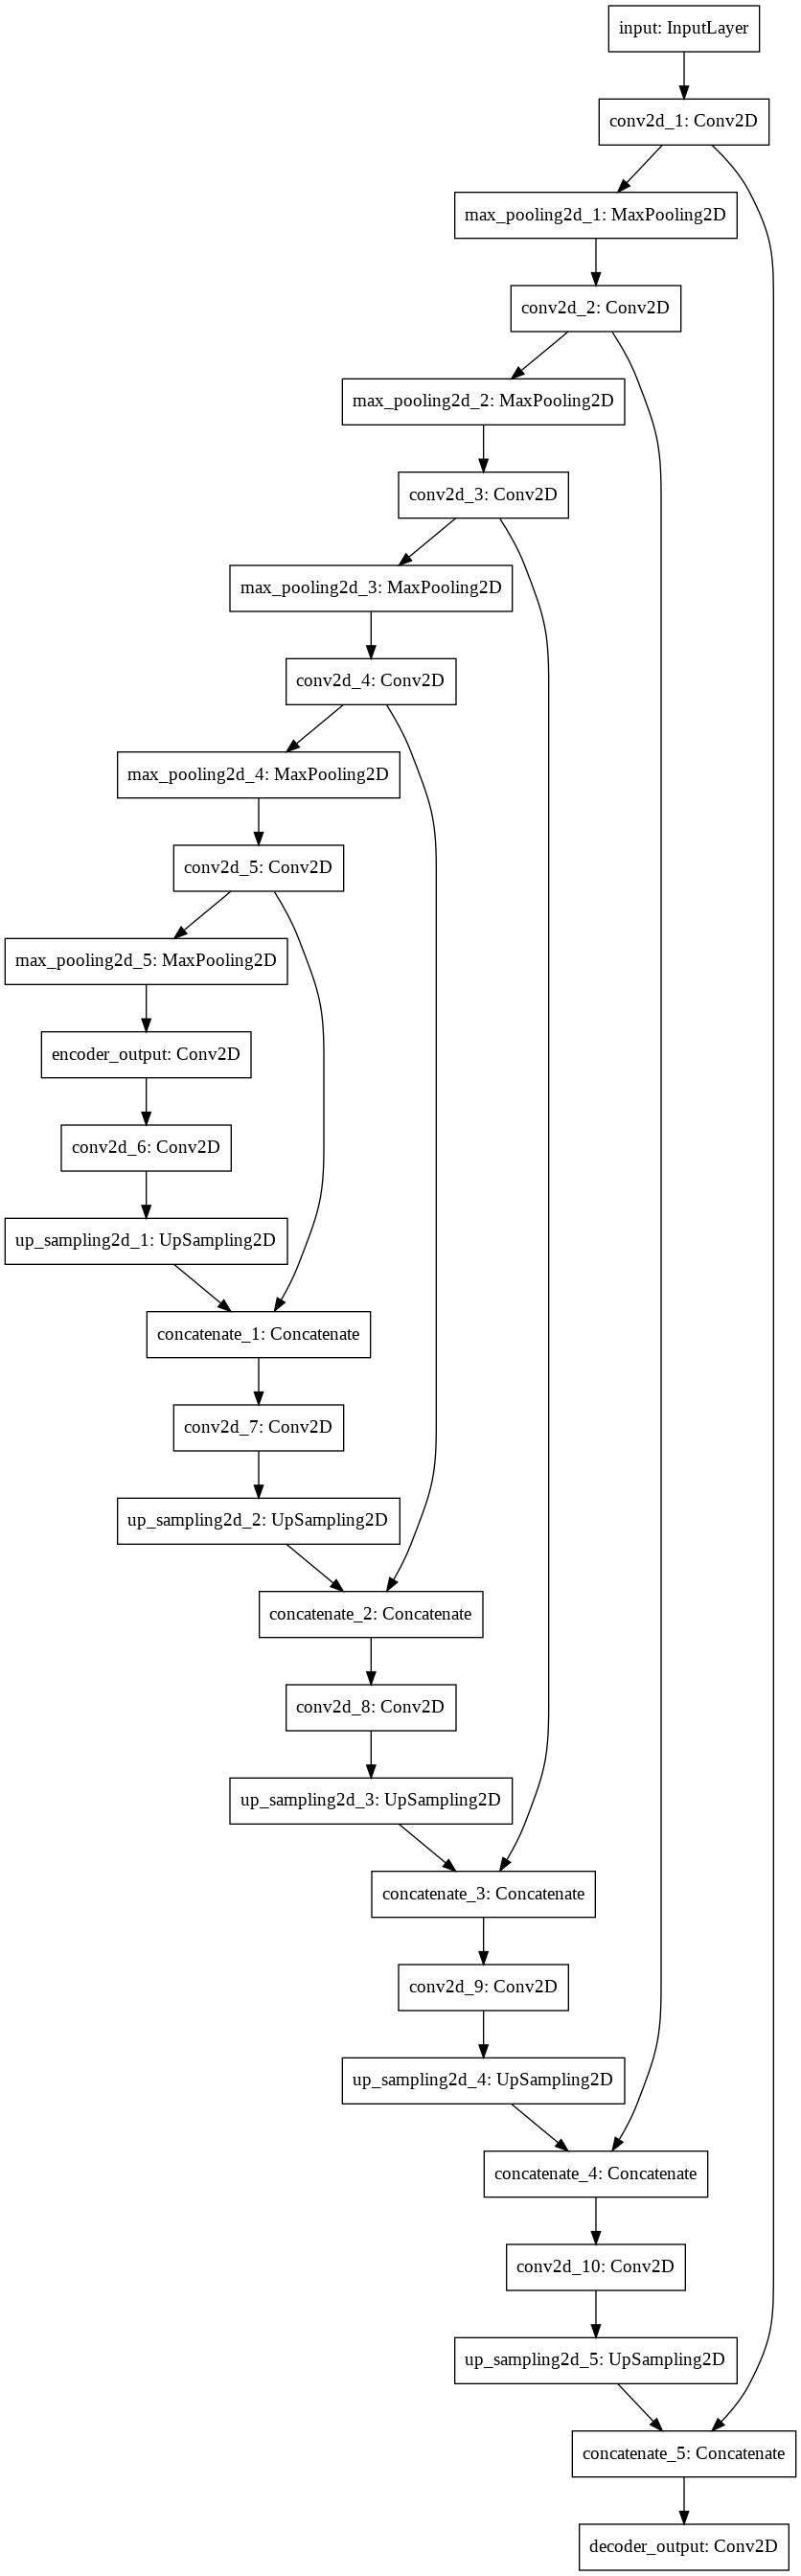

In [0]:
# Plot model summary to an image
plot_model(model, to_file='model_summary.png')

In [0]:
#Compile the model
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

In [0]:
# Define filepath for each model to be saved
oWeightFilePath = os.path.join(SAVE_MODEL_PATH, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")

# Create model checkpoint callback
iEpochs = 1
checkpoint_callback = ModelCheckpoint(oWeightFilePath, 
                                      monitor='val_loss', 
                                      verbose=1,  
                                      period=iEpochs)

# Create tensorboard callback
tensorboard_callback = TensorBoard(log_dir=LOGS_PATH, 
                                   batch_size=BATCH_SIZE, 
                                   write_graph=True, 
                                   write_grads=True, 
                                   write_images=True, 
                                   update_freq='epoch')

In [0]:
# Train the model
history = model.fit(x=oTrainImgArrayNp, 
                    y=oTrainImgArrayNp, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    callbacks=[checkpoint_callback, tensorboard_callback], 
                    validation_data=(oValImgArrayNp, oValImgArrayNp))


Train on 2736 samples, validate on 342 samples


Epoch 1/15
2736/2736 [==============================] - 23s 8ms/step - loss: 0.0161 - accuracy: 0.4982 - val_loss: 0.0023 - val_accuracy: 0.2826

Epoch 00001: saving model to ./weights/weights-improvement-01-0.28.hdf5

Epoch 2/15
2736/2736 [==============================] - 15s 6ms/step - loss: 0.0017 - accuracy: 0.6364 - val_loss: 0.0013 - val_accuracy: 0.6086

Epoch 00002: saving model to ./weights/weights-improvement-02-0.61.hdf5
Epoch 3/15
2736/2736 [==============================] - 15s 6ms/step - loss: 0.0016 - accuracy: 0.5142 - val_loss: 5.8655e-04 - val_accuracy: 0.3590

Epoch 00003: saving model to ./weights/weights-improvement-03-0.36.hdf5
Epoch 4/15
2736/2736 [==============================] - 15s 6ms/step - loss: 4.4252e-04 - accuracy: 0.3438 - val_loss: 3.7818e-04 - val_accuracy: 0.3285

Epoch 00004: saving model to ./weights/weights-improvement-04-0.33.hdf5
Epoch 5/15
2736/2736 [==============================] - 15s 6ms/s

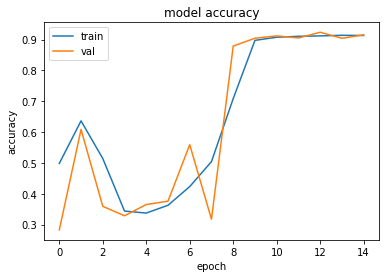

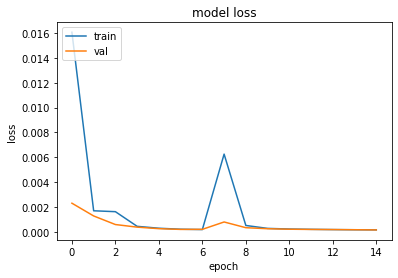

In [0]:
#Function to plot model history
def plot_model_history(history):
  
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy_curve.png')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

#Plot model history
plot_model_history(history)

In [0]:
# Load the best model
model = load_model("./weights/weights-improvement-15-0.92.hdf5")

# Save the model and weights as autoencoder model
model.save('./autoencoder.hdf5')

# Load the encoder of the best model
encoder = Model(inputs=model.input, outputs=model.get_layer('encoder_output').output)

# Save the encoder
encoder.save('./encoder.hdf5')

In [0]:
#Evaluate the model
oTrainScore = model.evaluate(oTrainImgArrayNp, oTrainImgArrayNp, batch_size=BATCH_SIZE)
oValScore = model.evaluate(oValImgArrayNp, oValImgArrayNp, batch_size=BATCH_SIZE)

print("oTrainScore: " , oTrainScore)
print("oValScore: ", oValScore)

342/342 [==============================] - 1s 2ms/step
oTrainScore:  [0.00015089131095371758, 0.9162279367446899]
oValScore:  [0.00015422591815494294, 0.9154034852981567]


In [0]:
# Calculate reconstruction Mean Squared Error
reconstruction_mse = model.evaluate(oTestImgArrayNp, oTestImgArrayNp, batch_size=BATCH_SIZE, verbose=0)
print("Autoencoder MSE:", reconstruction_mse)

Autoencoder MSE: [0.0001520900408416028, 0.9144245386123657]


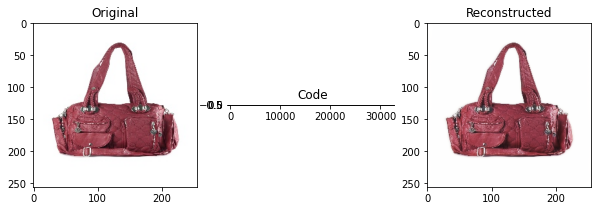

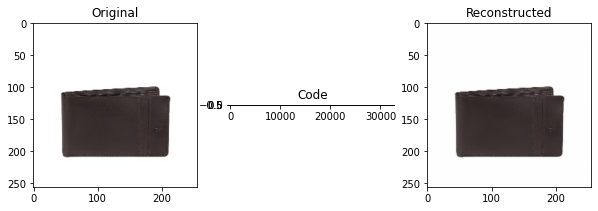

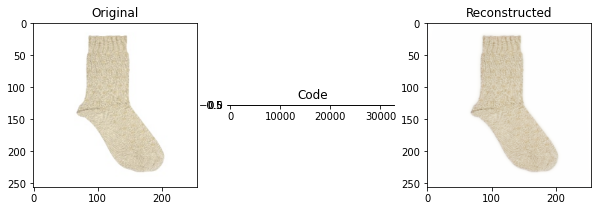

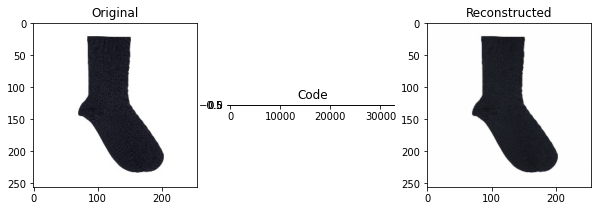

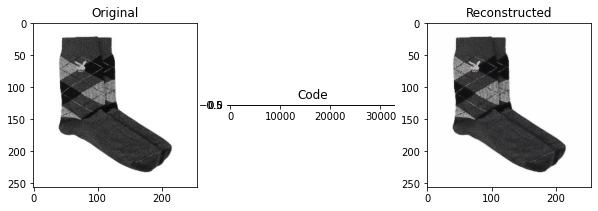

In [0]:
# Define bottleneck layer or encoding size
ENCODING_SIZE = 8*8*512

# Function to visualize test images reconstruction
def visualize(oImg, encoder, decoder):

    """Draws original, encoded and decoded images"""
    oCode = encoder.predict(oImg[None])[0]  # img[None] is the same as img[np.newaxis, :]
    oReconstructedImg = model.predict(oImg[None])[0]

    f, ax = plt.subplots(1,3, figsize=(10,9))
    ax[0].imshow(np.clip(oImg, 0, 1))
    ax[0].title.set_text('Original')
    ax[1].imshow(oCode.reshape(1, ENCODING_SIZE))
    ax[1].title.set_text('Code')
    ax[2].imshow(np.clip(oReconstructedImg, 0, 1))
    ax[2].title.set_text('Reconstructed')
    plt.show()

for i in range(5):
    oImg = oTestImgArrayNp[i]
    visualize(oImg, encoder, model)

In [0]:
#Calculate predictions
oTestPredictionsNp = model.predict(oTestImgArrayNp)

print("oTestImgArrayNp.shape", oTestImgArrayNp.shape)
print("oTestPredictionsNp.shape", oTestPredictionsNp.shape)

oPredictionsNp = np.ravel(oTestPredictionsNp)
oTestActualsNp  = np.ravel(oTestImgArrayNp)

print("oTestActualsNp.shape", oTestActualsNp.shape)
print("oPredictionsNp.shape", oPredictionsNp.shape)

oTestImgArrayNp.shape (342, 256, 256, 3)
oTestPredictionsNp.shape (342, 256, 256, 3)
oTestActualsNp.shape (67239936,)
oPredictionsNp.shape (67239936,)


In [0]:
y_true = oTestActualsNp
y_prediction = oPredictionsNp

print("Testing Mean Squared Error...")
print(mean_squared_error(y_true, y_prediction))

print("Testing Mean Absolute Error...")
print(mean_absolute_error(y_true, y_prediction))

Testing Mean Squared Error...
0.00015208915
Testing Mean Absolute Error...
0.0050685476


In [0]:
QUERY_COUNT = 5
QUERY_INDICES = [random.randrange(1, 100, 1) for i in range(QUERY_COUNT)]
NEAREST_NEIGHBOURS_COUNT = 5

# Delete the query images from the testing set
oNewTestImgArrayNp = np.delete(oTestImgArrayNp, QUERY_INDICES, axis=0)
print("oNewTestImgArrayNp.shape", oNewTestImgArrayNp.shape)

oNewTestImgArrayNp.shape (338, 256, 256, 3)


In [0]:
# Create encodings of query images
oQueryImg = []
for i in range(QUERY_COUNT):
  query = oTestImgArrayNp[QUERY_INDICES[i]]
  oQueryImg.append(query)

oQueryCode = []
for i in range(QUERY_COUNT):
    oQueryImgCode = encoder.predict(oQueryImg[i].reshape(1,256,256,3))
    oQueryCode.append(oQueryImgCode)
oQueryCodesNp = np.array(oQueryCode)
print("oQueryCodeNp.shape", oQueryCodesNp.shape)

oQueryCodeNp.shape (5, 1, 8, 8, 512)


In [0]:
# Reshape query images encodings
oQueryCodeNp = oQueryCodesNp.reshape(-1, 8*8*512)
print("oQueryCodeNp.shape", oQueryCodeNp.shape)

oQueryCodeNp.shape (5, 32768)


In [0]:
# Create encodings of new testing set
oNewTestImgCodeNp = encoder.predict(oNewTestImgArrayNp)
print("oNewTestImgCodeNp.shape", oNewTestImgCodeNp.shape)

oNewTestImgCodeNp.shape (338, 8, 8, 512)


In [0]:
# Reshape new test set encodings
oNewTestImgCodeNp = oNewTestImgCodeNp.reshape(-1, ENCODING_SIZE)
print("oNewTestImgCodeNp.shape", oNewTestImgCodeNp.shape)

oNewTestImgCodeNp.shape (338, 32768)


In [0]:
# Use nearest neighbor algorithm
nbrs = NearestNeighbors(n_neighbors=NEAREST_NEIGHBOURS_COUNT, metric="euclidean")
nbrs.fit(oNewTestImgCodeNp)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
# Find indices of nearest neighbors and the __distance
d = []
ind = []
for i in range(QUERY_COUNT):
    p = oQueryCodeNp[i].reshape(1,-1)
    distances, indices = nbrs.kneighbors(p)
    print("Query Image:", i+1)
    print("Distances :", distances)
    print("Indices :", indices)
    d.append(distances)
    ind.append(indices)

Query Image: 1
Distances : [[0.59992308 0.60164744 0.65608748 0.68253931 0.68405376]]
Indices : [[111 109 315 124  25]]
Query Image: 2
Distances : [[1.00944873 1.45565962 1.56749685 1.66820118 1.66844985]]
Indices : [[306  12  96  50 156]]
Query Image: 3
Distances : [[0.16950377 0.22584335 0.2617323  0.26347937 0.26747783]]
Indices : [[ 28 246 264   1 147]]
Query Image: 4
Distances : [[0.16950377 0.22584335 0.2617323  0.26347937 0.26747783]]
Indices : [[ 28 246 264   1 147]]
Query Image: 5
Distances : [[1.07096791 1.1042137  1.12374343 1.17032107 1.24707305]]
Indices : [[154 257  85 184 192]]


In [0]:
close = []
for i in range(QUERY_COUNT):

  oClosestImgs = oNewTestImgArrayNp[ind[i]]
  oClosestImgs = oClosestImgs.reshape(-1,256,256,3)
  close.append(oClosestImgs)

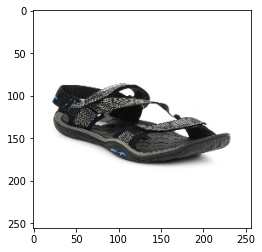

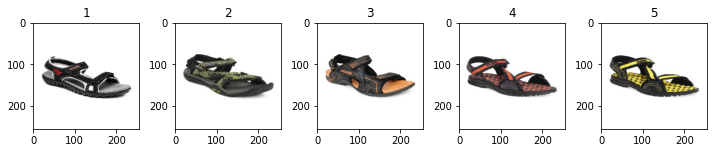

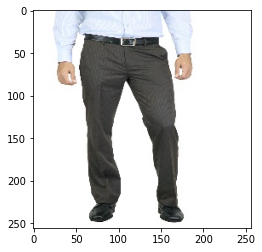

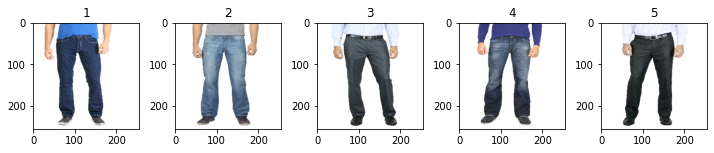

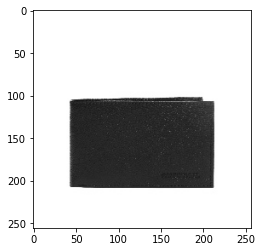

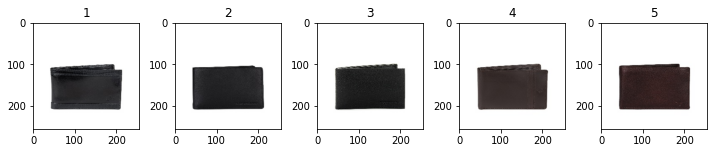

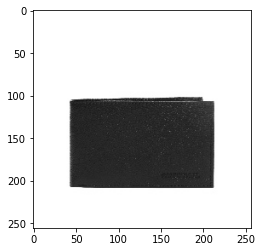

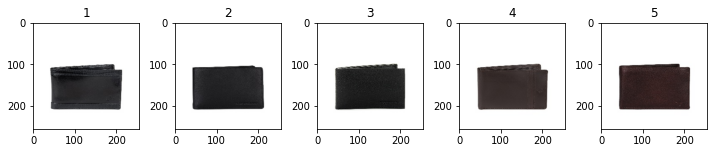

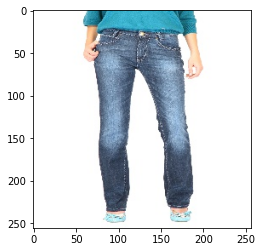

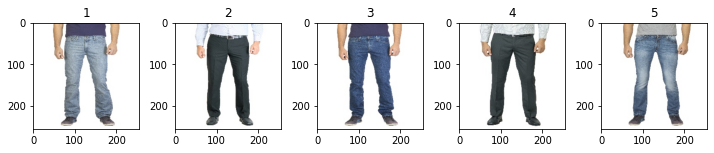

In [0]:
# for j in range(QUERY_COUNT):
#   plt.imshow(oTestImgArrayNp[QUERY_INDICES[j]])
#   plt.show()
#   c = close[j]
#   fig, ax = plt.subplots(1,5, figsize=(10,9))
#   for i in range(NEAREST_NEIGHBOURS_COUNT):
#     ax[i].imshow(c[i])
#     ax[i].title.set_text(str(i+1))
#     ax[i].get_xaxis().set_visible(True)
#     ax[i].get_yaxis().set_visible(True)
#     fig.tight_layout(pad=1.0) 

#   plt.show()

#Function to print the test results
def save_test_results(oTestImgArrayNp, oTestMaskArrayNp, oTestPredictionsNp):
    for j in range(QUERY_COUNT):
        plt.imshow(oTestImgArrayNp[QUERY_INDICES[j]])
        plt.show()
        c = close[j]

        f, ax = plt.subplots(1,5, figsize=(10,9))
        for i in range(NEAREST_NEIGHBOURS_COUNT):
            ax[i].imshow(c[i])
            ax[i].title.set_text(str(i+1))
            ax[i].get_xaxis().set_visible(True)
            ax[i].get_yaxis().set_visible(True)
            fig.tight_layout(pad=1.0)
        
        plt.savefig(os.path.join(SAVE_RESULTS_PATH, "test" + str(i) + ".png"))
        plt.show()

#Save test results
save_test_results(oTestImgArrayNp, oTestMaskArrayNp, oTestPredictionsNp)

In [0]:
# Configure Google drive to export data
from colab_util import *
drive_handler = GoogleDriveHandler()

In [0]:
def upload_files_to_drive(archive_name, files_to_be_archived):

  # Create a combined tar file
  tar_file_path = create_archive(archive_name, local_file_paths=files_to_be_archived, temp_folder='.', verbose=True)
  
  # Create folder inside google drive 
  project_folder_id = drive_handler.create_folder('Reverse_Image_Search')

  # Upload the data
  drive_handler.upload(tar_file_path, parent_path='Reverse_Image_Search')

In [0]:
# Upload processed image np arrays to google drive
upload_files_to_drive(archive_name="image_array_archive", 
                      files_to_be_archived = ["./pickled_data/oTrainImgArrayNp.pickle",
                                              "./pickled_data/oValImgArrayNp.pickle",
                                              "./pickled_data/oTestImgArrayNp.pickle"])

ignore the common prefix ./pickled_data/
running shell command: 
tar -czvf ./image_array_archive.tar.gz -C ./pickled_data/ oTrainImgArrayNp.pickle oValImgArrayNp.pickle oTestImgArrayNp.pickle
oTrainImgArrayNp.pickle
oValImgArrayNp.pickle
oTestImgArrayNp.pickle



In [0]:
# Upload model summary and curves to google drive
upload_files_to_drive(archive_name="curves_and_summary_archive", 
                      files_to_be_archived = ["./model_summary.png",
                                              "./accuracy_curve.png",
                                              "./loss_curve.png"])

ignore the common prefix ./
running shell command: 
tar -czvf ./curves_and_summary_archive.tar.gz -C ./ model_summary.png accuracy_curve.png loss_curve.png
model_summary.png
accuracy_curve.png
loss_curve.png

Reverse_Image_Search already exists


In [0]:
# Upload the best model and weights to google drive
upload_files_to_drive(archive_name="encoder_and_model_archive", 
                      files_to_be_archived = ["./autoencoder.hdf5", "./encoder.hdf5"])

ignore the common prefix ./
running shell command: 
tar -czvf ./encoder_and_model_archive.tar.gz -C ./ autoencoder.hdf5 encoder.hdf5
autoencoder.hdf5
encoder.hdf5

Reverse_Image_Search already exists


In [0]:
upload_files_to_drive(archive_name="tensorboard_graph_archive", 
                      files_to_be_archived = ["./graphs/events.out.tfevents.1590465876.c446ef9cd2e0"])

ignore the common prefix ./graphs/
running shell command: 
tar -czvf ./tensorboard_graph_archive.tar.gz -C ./graphs/ events.out.tfevents.1590465876.c446ef9cd2e0
events.out.tfevents.1590465876.c446ef9cd2e0

Reverse_Image_Search already exists
